In [4]:
# import necessary packages
import cdt
import ges
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

np.random.seed(0)

# Score-based algorithm (GES)

In [5]:
df = pd.read_stata("data/close_college.dta")
display(df.head())
df.shape

,nearc4,educ,black,smsa,south,married,exper,lwage
0,0,7,1,1,0,1.0,16,6.306275
1,0,12,0,1,0,1.0,9,6.175867
2,0,12,0,1,0,1.0,16,6.580639
3,1,11,0,1,0,1.0,10,5.521461
4,1,12,0,1,0,1.0,16,6.591674


(3010, 8)

In [6]:
def get_positions(input_df):
    x =  [0, 1, 1, 0, -1, -1, 0.5, -0.5]
    y =  [1, 0.5, -0.5, -1, -0.5, 0.5, 0, 0]
    x = [i*4 for i in x]
    y = [i*4 for i in y]

    pos = dict()
    for i in range(len(input_df.columns)):
        node = list(input_df.columns.values)[i]
        pos[node] = (x[i], y[i])

    return pos

pos = get_positions(df)
print(pos)

{'nearc4': (0, 4), 'educ': (4, 2.0), 'black': (4, -2.0), 'smsa': (0, -4), 'south': (-4, -2.0), 'married': (-4, 2.0), 'exper': (2.0, 0), 'lwage': (-2.0, 0)}


In [7]:
df = df.dropna()

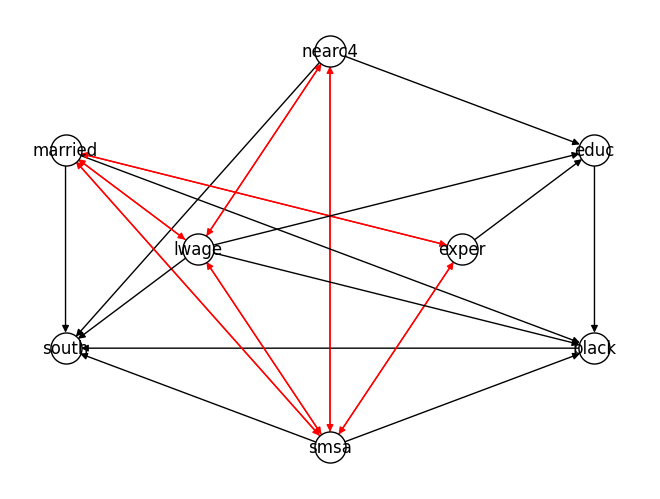

In [13]:
result, score = ges.fit_bic(df.to_numpy()) # The result is a CPDAG represented by an adjacency matrix
ges_graph = nx.relabel_nodes(nx.DiGraph(result), {idx: i for idx, i in enumerate(df.columns)})
colors = ['red'  if (y,x) in ges_graph.edges() else 'black' for (x,y) in ges_graph.edges()]
nx.draw(ges_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', edge_color=colors, pos=pos)

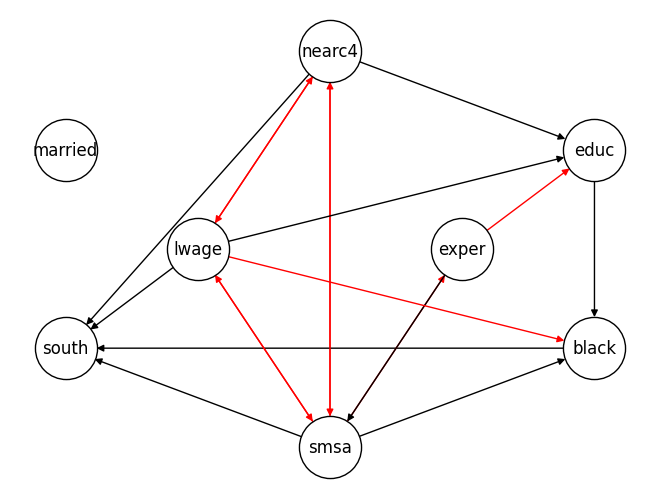

In [9]:
def remove_married_edges(graph):
    edges_to_remove = []
    for edge in graph.edges():
        if 'married' in edge:
            edges_to_remove.append(edge)
    graph.remove_edges_from(edges_to_remove)

remove_married_edges(ges_graph)
nx.draw(ges_graph, with_labels=True, node_size=2000, node_color='w', edgecolors ='black', edge_color=colors, pos=pos)


# Step-by-step:

In [10]:
nodes = ['nearc4', 'educ', 'black', 'smsa',  'south', 'married', 'exper', 'lwage']

# Containers to hold data from intermediate steps
inter_adjs = []
inter_scores = []
inter_phases = []

# Initialization
score_class = ges.scores.gauss_obs_l0_pen.GaussObsL0Pen(df.to_numpy()) # initalize the Gaussian BIC score (with numpy array)
cpdag = np.zeros((len(nodes), len(nodes))) # Initialize empty CPDAG as adjacency matrix
score = 0

# Run phases
for phase in [ges.forward_step, ges.backward_step]: # Run forward then backward phase
    print('GES {} phase start'.format(phase.__name__))
    while True: # Continue while we can increase the score in the current phase
        score_change, dag = phase(cpdag, score_class, 2) # Compute best possible score change and corresponding DAG
        if score_change > 0: # The score can be increased
            cpdag = ges.utils.pdag_to_cpdag(dag) # Get CPDAG of DAG
            score += score_change # Update total score

            # Save intermediate state
            inter_adjs.append(cpdag)
            inter_scores.append(score)
            inter_phases.append(phase.__name__)

            # Print intermediate state
            print('New score: {0:.4f}'.format(score))
            [print(row) for row in cpdag]
            print()
        else: # The score cannot be increased thus we end the phase
            break

GES forward_step phase start
  56 candidate edges
    insert(0,1,[]) -> 27.4589229954390248
    insert(0,2,[]) -> 4.5112245288357826
    insert(0,3,[]) -> 195.7915975645527169
    insert(0,4,[]) -> 72.1325139221105474
    insert(0,5,[]) -> -3.6164622648111617
    insert(0,6,[]) -> 2.0056321439287785
    insert(0,7,[]) -> 35.9139046965556190
    insert(1,0,[]) -> 27.4589229954399343
    insert(1,2,[]) -> 107.6094441246489168
    insert(1,3,[]) -> 50.0195787541367736
    insert(1,4,[]) -> 57.8128348929024014
    insert(1,5,[]) -> 3.5780211610658625
    insert(1,6,[]) -> 832.1854163966881970
    insert(1,7,[]) -> 152.4103328426758708
    insert(2,0,[]) -> 4.5112245288354416
    insert(2,1,[]) -> 107.6094441246486895
    insert(2,3,[]) -> -1.8776880280379373
    insert(2,4,[]) -> 182.1859661181352976
    insert(2,5,[]) -> 13.8724651313227696
    insert(2,6,[]) -> 24.9022565462555576
    insert(2,7,[]) -> 141.2950521246705193
    insert(3,0,[]) -> 195.7915975645527169
    insert(3,1,[]) -> 

# The following could should generate the same graph, but I cannot run it

In [11]:
import os
os.environ['R_HOME'] = "C:/PROGRA~1/R/R-43~1.1" # PATH FEMKE

%load_ext rpy2.ipython

# import necessary packages
from itertools import combinations

import cdt
# cdt.SETTINGS.rpath = '/usr/local/bin/Rscript' # for macOS
# cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.0.3/bin/Rscript' # for Windows
cdt.SETTINGS.rpath = 'C:/PROGRA~1/R/R-43~1.1/bin/Rscript' # for FEMKE PATH



#from dowhy import CausalModel
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from numpy.random import normal
import pandas as pd
import pingouin as pg

np.random.seed(0)

The symbol 'quartz' is not in this R namespace/package.
The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.


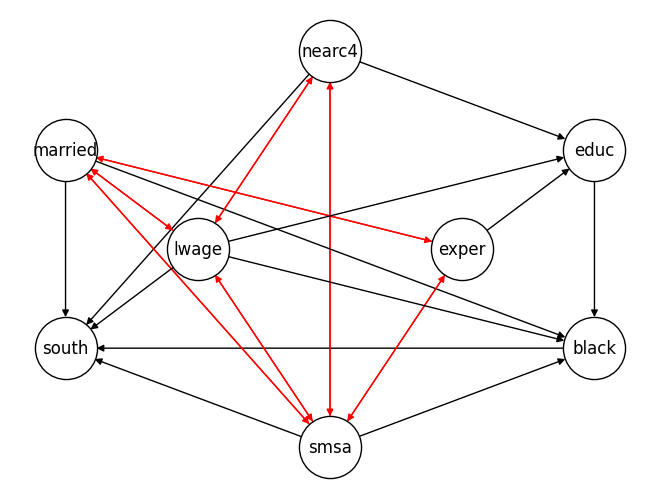

In [18]:
cdt_gres_graph = cdt.causality.graph.GES(score='obs').predict(df)
colors = ['red'  if (y,x) in cdt_gres_graph.edges() else 'black' for (x,y) in cdt_gres_graph.edges()]
nx.draw(cdt_gres_graph, with_labels=True, node_size=2000, node_color='w', edgecolors ='black', edge_color=colors, pos=pos)
# nx.write_gml(cdt_gres_graph, f"graph_files/cdt_gres_graph.gml")

In [16]:
# nx.write_gml(cdt_gres_graph, "cdt_gres_graph.gml")
cdt_gres_graph= nx.read_gml("cdt_gres_graph.gml")
nx.draw(cdt_gres_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', edge_color=colors, pos=pos)

FileNotFoundError: [Errno 2] No such file or directory: 'cdt_gres_graph.gml'